# Python II - Assignment 2

This **Home Assignment** is to be submitted and you will be given points for each of the tasks. It familiarizes you with basics of *web scraping* and basics of *regular expressions*.

## Formalities
**Submit in a group of 2-3 people until 22.06.2020 23:59CET. The deadline is strict!**

## Evaluation and Grading
General advice for programming excercises at *CSSH*:
Evaluation of your submission is done semi automatically. Think of it as this notebook being 
executed once. Afterwards, some test functions are appended to this file and executed respectively.

Therefore:
* Submit valid _Python3_ code only!
* Use external libraries only when specified by task.
* Ensure your definitions (functions, classes, methods, variables) follow the specification if
  given. The concrete signature of e.g. a function usually can be inferred from task description, 
  code skeletons and test cases.
* Ensure the notebook does not rely on current notebook or system state!
  * Use `Kernel --> Restart & Run All` to see if you are using any definitions, variables etc. that 
    are not in scope anymore.
  * Double check if your code relies on presence of files or directories other than those mentioned
    in given tasks. Tests run under Linux, hence don't use Windows style paths 
    (`some\path`, `C:\another\path`). Also, use paths only that are relative to and within your
    working directory (OK: `some/path`, `./some/path`; NOT OK: `/home/alice/python`, 
    `../../python`).
* Keep your code idempotent! Running it or parts of it multiple times must not yield different
  results. Minimize usage of global variables.
* Ensure your code / notebook terminates in reasonable time.

**There's a story behind each of these points! Don't expect us to fix your stuff!**

Regarding the scores, you will get no points for a task if:
- your function throws an unexpected error (e.g. takes the wrong number of arguments)
- gets stuck in an infinite loop
- takes much much longer than expected (e.g. >1s to compute the mean of two numbers)
- does not produce the desired output (e.g. returns an descendingly sorted list even though we asked for ascending, returns the mean and the std even though we asked for the mean only, only prints the output instead of returning it!)
- ...

In [1]:
# credentials of all team members (you may add or remove items from the dictionary)
team_members = [
    {
        'first_name': '',
        'last_name': '',
        'student_id': 1111
    },
    {
        'first_name': 'Poorya',
        'last_name': 'Khanali Satarerazleghi',
        'student_id': 381198
    }
]

# History in Wikipedia (10 points total)

Wikipedia has a lot of information on historic events. Assume you want to conduct a study that examines which language edition talks more about different historic event (as indicated by years). As an example you first consider the article "History_of_Germany" in the englisch and german wikipedia.

To get articles from the web, use the `requests` library. To deal with html content you can use the Beautiful soup library.

In [2]:
import requests
from bs4 import BeautifulSoup
import os
import re

## a) Grabbing a wikipedia article (1 + 0.5 + 0.5 + 0.5)
Write a function `get_article_from_web(article_name, language_edition)` that returns the HTML as string for that article in a specific language edition. Assume that the article exists.

To save bandwith when conducting multiple experiments we want to setup a cache of wikipedia articles.
To setup the cache write the function `save_article_to_disk(article_name, language_edition, content)` that saves the content for that wikipedia article in `'./cache/{language_edition}/{article_name}.html'`. If any of the folders do not exist they are created. Please read the information on evaluation and grading.


Then write a function `get_article_from_disk(article_name, language_edition)` that returns the cached version of the article from disk. If the article does not exists, it raises a `ValueError`.


Write a function `get_article(article_name, language_edition)` that uses a local cache for fetching articles from wikipedia. So if you that article exists in cache it returns the cached version. If not it fetches the html for that article from the web and writes it to the cache so there is no need to get it from the web the next time. Thereby use the previously defined functions.

Use the "caching" version `get_article` for all of the following tasks.

In [3]:
def get_article_from_web(article_name, language_edition):
    
    global API_URL
    API_URL = f"https://{language_edition}.wikipedia.org/wiki/{article_name}"
    response = requests.get(API_URL,timeout=30)

    if response is not None:
        html = BeautifulSoup(response.text, 'html.parser')

        #the title of the article
        title = html.select("#firstHeading")[0]
        paragraphs = html.select("p")
        # just grab the text up to contents as stated in question
        html_text = ''.join([ str(para) for para in paragraphs])
        #print (intro)
    return html_text

In [4]:
def save_article_to_disk(article_name, language_edition, content):
    try:
        os.makedirs(f"./cache/{language_edition}")
    except :
        pass
    
    my_file=open(f"./cache/{language_edition}/{article_name}.html","w", encoding="utf-8")
    my_file.write(content)
    my_file.close()

In [5]:
def get_article_from_disk(article_name, language_edition):
    try:
        with open(f"./cache/{language_edition}/{article_name}.html","r",encoding="utf-8") as f:
            return f.read()
    except FileNotFoundError: 
        raise ValueError("The article does not exists")

In [6]:
def get_article(article_name, language_edition):
    try:
        return get_article_from_disk(article_name,language_edition)
    except:
        content=get_article_from_web(article_name,language_edition)
        save_article_to_disk(article_name,language_edition,content)
        return get_article_from_disk(article_name,language_edition)

In [7]:
get_article("Germany","en")

'<p class="mw-empty-elt">\n</p><p>\n<span style="font-size: small;"><span id="coordinates"><a href="/wiki/Geographic_coordinate_system" title="Geographic coordinate system">Coordinates</a>: <span class="plainlinks nourlexpansion"><a class="external text" href="//tools.wmflabs.org/geohack/geohack.php?pagename=Germany&amp;params=51_N_9_E_"><span class="geo-default"><span class="geo-dms" title="Maps, aerial photos, and other data for this location"><span class="latitude">51°N</span> <span class="longitude">9°E</span></span></span><span class="geo-multi-punct">\ufeff / \ufeff</span><span class="geo-nondefault"><span class="geo-dec" title="Maps, aerial photos, and other data for this location">51°N 9°E</span><span style="display:none">\ufeff / <span class="geo">51; 9</span></span></span></a></span></span></span>\n</p><p style="text-align:left;margin-left:1.2ex;margin-top:0px;margin-bottom:0px;line-height:1.15em;">–\xa0in <a href="/wiki/Europe" title="Europe">Europe</a>\xa0(light green &amp;

## b) Links from one article to other articles  (1)
Write a function `get_links(article_name, language_edition)` that returns a list of wikipedia article names.  These links are obtained throught the article specified by `article_name` (in the language_edition). Only include links in its 'content' div. Do not include links that you can get through the left navigation bar.

Sort the links in alphabetically increasing order.

In [8]:
def get_links(article_name, language_edition):
    page_content = get_article(article_name, language_edition)
    # convert the string file to soup
    soup = BeautifulSoup(page_content, 'html.parser')
    names = []
    for link in soup.find_all("a"):
        l=str(link.get('href'))
        if l.startswith("/w") and ('Wikipedia' not in l) and ('index' not in l) and ("File" not in l):
            b=link.get('title')
            if b not in names:
                names.append(str(b))
    return sorted(names)

In [9]:
get_links("Germany","en")

['1933 German referendum',
 '1936 Summer Olympics',
 '1936 Winter Olympics',
 '1972 Summer Olympics',
 '1999 NATO bombing in Yugoslavia',
 '2005 German federal election',
 '2011 German Census',
 '2017 German federal election',
 '20th-century classical music',
 '24 Hours of Le Mans',
 'Aachen Cathedral',
 'Abdication',
 'Abitur',
 'Academy Award for Best Foreign Language Film',
 'Action T4',
 'Adidas',
 'Adolf Hitler',
 'Advent wreath',
 'Afghanistan',
 'Aftermath of World War II',
 'Age of Enlightenment',
 'Ageing of Europe',
 'Ahmadiyya',
 'Albrecht Dürer',
 'Alevites',
 'All-time Olympic Games medal count',
 "Alliance '90/The Greens",
 'Allianz',
 'Allied-occupied Germany',
 'Allies of World War I',
 'Allies of World War II',
 'Alps',
 'Alternative for Germany',
 'Analytic philosophy',
 'Angela Merkel',
 'Anschluss',
 'Arabic',
 'Archduke Franz Ferdinand of Austria',
 'Arminius',
 'Armistice with Germany',
 'Art Deco',
 'Art Nouveau',
 'Art of Europe',
 'Arthur Schopenhauer',
 'Assas

## c) Getting the same article in a different language edition (1.0)
Write a funciton `switch_language(article_name, old_language_edition, new_language_edition)` that returns the name of the wikipedia article in the new language edition.

In [10]:
def switch_language(article_name, old_language_edition, new_language_edition):
    # we have to read the whole page because the name of new language is not in the body of HTML 
    # extracted from "get_article"

    URL = f"https://{old_language_edition}.wikipedia.org/wiki/{article_name}"
    page = requests.get(url=URL,timeout=30)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    wiki_new_lang = soup.find_all(class_="interlanguage-link-target",lang=new_language_edition)
    new_name_article = " ".join(wiki_new_lang[0]['title'].split()[:-2]) 
    return new_name_article

In [11]:
switch_language("History_of_Germany","en", "fr")

"Histoire de l'Allemagne"

## d) Using regular expressions to extract years from a page content (1.5)
Write a function `extract_years(string_input)` that gets a string and returns how often a certain year number from 1000-2019 occurs. You can assume that each number between 1000 and 2020 is a year number. The result is a dictionary with year numbers as keys, and the number of occurrences as values.

Example: `extract_years("The king reigned from 1245 to 1268. He died in 1268. His favorite number was 12689")` should return the dictionary `{1245: 1, 1268:2}`

In [12]:
def extract_years(string_input):
    L=re.findall("\\b(1\d{3}|20[0-1]\d|2020)\\b",string_input)
    D={}
    for a in L:
        if a not in D:
            D[a]=L.count(a)
    return D

In [13]:
extract_years("The king reigned from 1245 to 1268. He died in 1268. His favorite number was 12689 and 2021 and 19999 and 2020")

{'1245': 1, '1268': 2, '2020': 1}

## e) Aggregate years for articles (0.5)
Write a function `extract_years_for_articles(article_names, language_edition)` that extracts the years counts for all the articles in that particular language edition and aggregates them into a single dictionary. This aggregated dictionary is returned.

In [14]:
def extract_years_for_articles(article_names, language_edition):
    
    dict_years = dict()
    for article_name in  article_names:
        
        page_content = get_article(article_name,language_edition)
        soup = BeautifulSoup(page_content, 'html.parser')
        text_extracted = soup.get_text()
        years_of_one_article = extract_years(text_extracted)
        
        # concatenate the dictionary of years
        for key,val in years_of_one_article.items():
                try:
                    # if the year (key) exist in the dictionary then adds the new value to its value
                    dict_years[key] = dict_years[key] + val
                except KeyError:
                    # if the year (key) does not exist in the dictionary then adds the new key and its corresponding value to it
                    dict_years[key] = val
        
    return dict_years

In [15]:
extract_years_for_articles(["Germany", "history_of_Germany"],"en")

{'1815': 11,
 '1871': 12,
 '1918': 19,
 '1919': 10,
 '1933': 21,
 '1990': 13,
 '1024': 2,
 '1125': 3,
 '1138': 1,
 '1254': 2,
 '1315': 1,
 '1348': 1,
 '1356': 3,
 '1517': 4,
 '1555': 4,
 '1618': 5,
 '1648': 9,
 '1495': 1,
 '1438': 2,
 '1740': 4,
 '1772': 3,
 '1793': 3,
 '1795': 4,
 '1806': 6,
 '1848': 8,
 '1862': 2,
 '1866': 3,
 '1882': 2,
 '1884': 1,
 '1914': 9,
 '1924': 3,
 '1929': 5,
 '1932': 9,
 '1935': 8,
 '1936': 9,
 '1938': 8,
 '1939': 11,
 '1940': 6,
 '1941': 6,
 '1942': 5,
 '1943': 2,
 '1944': 4,
 '1945': 15,
 '1949': 14,
 '1948': 6,
 '1955': 6,
 '1961': 4,
 '1989': 8,
 '1994': 4,
 '1999': 3,
 '2019': 10,
 '1992': 3,
 '2007': 3,
 '2005': 5,
 '2009': 4,
 '2015': 4,
 '2020': 5,
 '2016': 5,
 '1844': 4,
 '2017': 10,
 '2018': 7,
 '2011': 7,
 '2001': 1,
 '2014': 7,
 '2002': 3,
 '1386': 1,
 '1810': 3,
 '2013': 5,
 '1838': 1,
 '1854': 2,
 '1895': 2,
 '1912': 2,
 '1927': 1,
 '1979': 2,
 '1951': 1,
 '2012': 1,
 '1954': 1,
 '1974': 4,
 '1972': 2,
 '1980': 1,
 '1996': 1,
 '1803': 2,
 '190

## f) Bringing it all together (1.5)
Write a function `get_all_years(base_article, base_language_edition, n=None, target_language_edition=None)`

- Determines 'real' base article (if target_language edition is specified, the article in the target language edition is used.)
- extracts the first n links (all if n is None) from that 'real' base article
- aggregates the year counts across the base article **and** all the n articles that the base article links to.
- it then returns that dictionary

In [16]:
def get_all_years(base_article, base_language_edition, n=None, target_language_edition=None):
    
    def web_links(article_name, language_edition):
        page_content = get_article(article_name, language_edition)
        # convert the string file to soup
        soup = BeautifulSoup(page_content, 'html.parser')
        links = []
        for link in soup.find_all("a"):
            l=str(link.get('href'))
            if l.startswith("/w") and ('Wikipedia' not in l) and ('index' not in l) and ("File" not in l):
                b=f"https://{language_edition}.wikipedia.org"+l
                if b not in links:
                    links.append(b)
        return sorted(links)
    
    
    if target_language_edition is None:
        name_article = base_article
        language_edition = base_language_edition
        if n is None:
            link_list = web_links(base_article,base_language_edition)
        else:
            link_list = web_links(base_article,base_language_edition)[:n] 
    else:
        # switch language
        name_article = switch_language(base_article,base_language_edition, target_language_edition)
        language_edition = target_language_edition
        if n is None:
            link_list = web_links(name_article,target_language_edition)
        else:
            link_list = web_links(name_article,target_language_edition)[:n]
    
    article_names = [name_article]
    # extract the name of articles so we can use the names later to extract years
    for link in link_list:
        name_article_of_link = link.split(f"https://{language_edition}.wikipedia.org/wiki/")[1]
        article_names.append(name_article_of_link)
        
    
    return extract_years_for_articles(article_names, language_edition)

In [17]:
get_all_years("Germany","en",n=10,target_language_edition="de")

{'1949': 13,
 '1990': 19,
 '2018': 29,
 '1815': 6,
 '1871': 4,
 '1918': 20,
 '1933': 8,
 '1939': 71,
 '1945': 30,
 '1961': 5,
 '1989': 11,
 '2016': 57,
 '1365': 2,
 '1806': 6,
 '1948': 6,
 '2000': 12,
 '1493': 1,
 '1456': 1,
 '1000': 9,
 '1141': 1,
 '1929': 9,
 '2019': 26,
 '2013': 36,
 '1969': 6,
 '2011': 38,
 '2015': 40,
 '2017': 33,
 '1972': 3,
 '1955': 18,
 '1950': 6,
 '2002': 7,
 '2012': 27,
 '2007': 26,
 '1517': 3,
 '1970': 9,
 '1987': 4,
 '1200': 4,
 '1024': 1,
 '1077': 1,
 '1122': 1,
 '1250': 2,
 '1157': 1,
 '1254': 1,
 '1356': 1,
 '1437': 1,
 '1519': 1,
 '1555': 1,
 '1618': 1,
 '1648': 1,
 '1663': 1,
 '1803': 1,
 '1801': 1,
 '1805': 2,
 '1809': 1,
 '1812': 2,
 '1813': 2,
 '1814': 1,
 '1833': 1,
 '1834': 1,
 '1817': 1,
 '1832': 1,
 '1848': 3,
 '1849': 3,
 '1866': 4,
 '1867': 6,
 '1878': 2,
 '1884': 1,
 '1888': 1,
 '1914': 5,
 '1919': 9,
 '1920': 14,
 '1923': 4,
 '1921': 6,
 '1925': 5,
 '1924': 1,
 '1932': 4,
 '1930': 1,
 '1934': 13,
 '1935': 5,
 '1936': 4,
 '1938': 20,
 '1940':

## g) Visualize and Interpret your results (1 + 1)
Visualize the numbers of occurrences for the article History_of_Germany in both englisch (en) and german (de) in a timeline. Use `n=20`. Show the results here in the notebook and also save it to 'timeline.png' in code. Make sure the plot has a legend, axis labels, ...

Describe the visualization, and give reasons for possible differences of the german and englisch timelines. Write that string to a file 'timeline.txt'

In [18]:
years_en = get_all_years("History_of_Germany","en",n=20)
years_de = get_all_years("History_of_Germany","en",n=20,target_language_edition="de")

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [20]:
data_en = { 'year':list(years_en.keys()),'frequency': list(years_en.values())}
data_en = pd.DataFrame.from_dict(data_en)
data_en['language'] = 'en'
data_en.sort_values('frequency',ascending=False)

,year,frequency,language
9,1918,78,en
13,1938,54,en
14,1939,46,en
302,2011,44,en
11,1933,43,en
...,...,...,...
252,1902,1,en
253,1843,1,en
70,1742,1,en
69,1526,1,en


In [21]:
data_de = { 'year':list(years_de.keys()),'frequency': list(years_de.values())}
data_de = pd.DataFrame.from_dict(data_de)
data_de['language'] = 'de'
data_de.sort_values('frequency',ascending=False)

,year,frequency,language
161,1939,112,de
3,1933,58,de
160,1938,51,de
4,1945,49,de
176,1968,47,de
...,...,...,...
263,1859,1,de
95,1697,1,de
265,1861,1,de
120,1845,1,de


In [22]:
data = pd.concat([data_en,data_de])
data = data.sort_values('year',ascending=True)

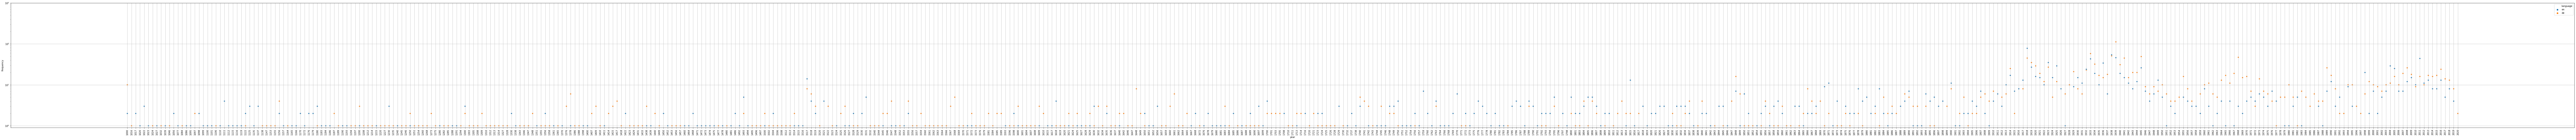

In [23]:
plt.figure(figsize=(200,10))
plt.yscale("log")
plt.ylim(.9,1000)
plt.grid(axis ='both')
plt.xticks(rotation=90)
sns.scatterplot(data['year'],data['frequency'],hue=data['language'])
plt.savefig("timeline.png")
plt.show()

In [24]:
timeline = """ As we can see there are some fluctuations specially in the early years from 1000 to 1900, but when there is a major event in the history of Germany or the world the number of referenced years increases drastically, for example around the WW1 and WW2 years, there are a significant growth in the diagram. In general, since the mid-twentieth century the amount of year increases gradually. We see that before 1914, the occurrence of years in the English version is more than the Deutch version, maybe because we lost some information in the Deutch version since Wikipedia is a global platform and English is more global than German that's why we have more information in English than German, but after 1914 we see that the occurrence is almost the same because that period has a big importance in the history that's why we don't see a big loss of information """
with open('timeline.txt', 'w') as f:
    f.write(timeline)